In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation
# Edits
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import pylcp
import pylcp.atom as atom
from pylcp.common import cart2spherical
from pylcp.fields import gaussianBeam
#plt.style.use('paper')

In [13]:
# 50 gauss/cm for Sr 
# mub on database
# 0.43 cm for x0 30/1.4/50

# x is length unit
# k is wavenumber which relates to wavelength
x0 = (30/1.4/50) # cm
k = 2*np.pi/461E-7 # cm^{-1}
kbar = k*x0

# D source for position
d = np.array([0., -8.839/10, -8.839/10])/x0

# Gamma is decay rate
# t0 is normalized time units of decary
# wb is width factor
gamma = 2*np.pi*30e6
t0 = 1e-5 # s
gammabar = gamma*t0
wb = 4.7 # mm


zchip = 1.0
nr=3

class aPHIMOT(pylcp.laserBeams):
     def __init__(self, *args, **kwargs):
        super().__init__()
    
        beam_type = kwargs.pop('beam_type', pylcp.laserBeam)
        pol = kwargs.pop('pol', +1)
        kmag = kwargs.pop('k', 1.)
        
        self.add_laser(beam_type(kmag*(np.array([0., 0.,  17.678])/(np.linalg.norm(np.array([0., 0.,  17.678])))), +pol, *args, **kwargs))
        self.add_laser(beam_type(kmag*(np.array([0., 0.,  -17.678])/(np.linalg.norm(np.array([0., 0.,  -17.678])))), +pol, *args, **kwargs))
        self.add_laser(beam_type(kmag*(np.array([10.825, -13.258, 4.419])/(np.linalg.norm(np.array([10.825, -13.258, 4.419])))), -pol, *args, **kwargs))
        self.add_laser(beam_type(kmag*(np.array([10.825, 13.258, -4.419])/(np.linalg.norm(np.array([10.825, 13.258, -4.419])))), -pol, *args, **kwargs))
        self.add_laser(beam_type(kmag*(np.array([-10.825, -13.258, 4.419])/(np.linalg.norm(np.array([-10.825, -13.258, 4.419])))), -pol, *args, **kwargs))
        self.add_laser(beam_type(kmag*(np.array([-10.825, 13.258, -4.419])/(np.linalg.norm(np.array([-10.825, 13.258, -4.419])))), -pol, *args, **kwargs))
        
class rotDivGauss(pylcp.laserBeams):
     def __init__(self, *args, **kwargs):
        super().__init__()
    
        beam_type = kwargs.pop('beam_type', pylcp.laserBeam)
        pol = kwargs.pop('pol', +1)
        kmag = kwargs.pop('k', 1.)
        beta = kwargs.pop('beta', 1.0)
        delta = kwargs.pop('delta', -1.5*gammabar)
        
        self.add_laser(pylcp.gaussianBeam(kvec=np.array([0., 0., -1.])*(np.array([0., 0., 0.])), \
                       pol=np.array([1., 1.j, 0]), beta=1.0*beta, delta=delta, wb=4.65, *args, **kwargs))
        self.add_laser(pylcp.gaussianBeam(kvec=np.array([0.612, 0.75, -0.25])*(np.array([0., 0., 0.])), \
                       pol=np.array([1., 1.j, 0]), beta=1.0*beta, delta=delta, wb=4.65, *args, **kwargs))
        self.add_laser(pylcp.gaussianBeam(kvec=np.array([-0.612, 0.75, -0.25])*(np.array([0., 0., 0.])), \
                       pol=np.array([1., -1.j, 0]), beta=1.0*beta, delta=delta, wb=4.65, *args, **kwargs))
        self.add_laser(pylcp.gaussianBeam(kvec=np.array([0., 0., 1.])*np.array([0., 0., -17.788])/(np.linalg.norm(np.array([0., 0., -17.788]))), \
                       pol=np.array([1., -1.j, 0]), beta=6.261e7*beta, delta=delta, wb=5.744e-4, *args, **kwargs))
        self.add_laser(pylcp.gaussianBeam(kvec=np.array([-0.612, -0.75, 0.25])*np.array([10.893, 13.341, -4.447])/(np.linalg.norm(np.array([10.893, 13.341, -4.447]))), \
                       pol=np.array([1., -1.j, 0]), beta=6.261e7*beta, delta=delta, wb=5.744e-4, *args, **kwargs))
        self.add_laser(pylcp.gaussianBeam(kvec=np.array([0.612, -0.75, 0.25])*np.array([-10.893, 13.341, -4.447])/(np.linalg.norm(np.array([-10.893, 13.341, -4.447]))), \
                       pol=np.array([1., -1.j, 0]), beta=6.261e7*beta, delta=delta, wb=5.744e-4, *args, **kwargs))
    

# Set up the laser beams with their appropriate characteristics
det = -1.5*gammabar
beta = 1.0

#beam_to_sim = pylcp.infinitePlaneWaveBeam
beam_to_sim = pylcp.gaussianBeam
#beam_to_sim = pylcp.clippedGaussianBeam

#MOT_to_sim = conventional3DMOTBeams
#MOT_to_sim = aPHIMOT
MOT_to_sim = rotDivGauss

#MOT_to_sim_kwargs = {'rotation_angles':[np.pi/4, 0., 0.]} # Extra arguments for conventional3DMOTBeams
MOT_to_sim_kwargs = {} # Extra arguments for aPHIMOT/rotDivGauss

laser_kwargs = {} # Use for rotDivGauss
#laser_kwargs = {'wb':wb} # Extra arguments for GaussianBeam
#laser_kwargs = {'wb':1000*wb, 'rs':wb} # Extra arguments for clippedGaussianBeam

In [17]:
k = np.array([1., 1., 1.])
k = k/np.linalg.norm(k)
#laserBeam = gaussianBeam(kvec=np.array([0., 0., 1.]), wb=20., pol=np.array([1., 1.j, 0]), r0=np.array([0., 0., 0.]))
laserBeam = pylcp.gaussianBeam(kvec=np.array([0., 0., -1.])*(np.array([0., 0., 0.])), \
                       pol=np.array([1., 1.j, 0]), beta=1.0*beta, delta=det, wb=4.65) # kbar

laserBeam.local_parameters(np.array([100., 10., 1.]), 0.)

C:\Users\leow0\Documents\GitHub\pylcp\fields.py:907: RuntimeWarning: invalid value encountered in true_divide
  self.con_khat = kvec/self.con_kmag
C:\Users\leow0\Documents\GitHub\pylcp\fields.py:913: RuntimeWarning: divide by zero encountered in double_scalars
  self.wavelength = 2*np.pi/(np.linalg.norm(kvec))


(array([nan, nan, nan]), array([nan+nanj, nan+nanj, nan+nanj]), nan)

C:\Users\leow0\anaconda3\lib\site-packages\matplotlib\image.py:397: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
C:\Users\leow0\anaconda3\lib\site-packages\matplotlib\image.py:398: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
C:\Users\leow0\anaconda3\lib\site-packages\matplotlib\image.py:405: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
C:\Users\leow0\anaconda3\lib\site-packages\matplotlib\image.py:410: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
C:\Users\leow0\anaconda3\lib\site-packages\numpy\ma\core.py:722: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


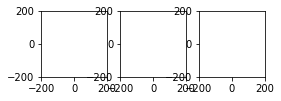

In [18]:
x_beta = 200
X, Y = np.meshgrid(np.linspace(-x_beta, x_beta, 101),
                   np.linspace(-x_beta, x_beta, 101))
z_tests = [-1*laserBeam.zr, 0, laserBeam.zr] # position

plt.figure("Laser Beams", figsize=(4, 1.5*6)) # 6 beams
plt.clf()
# pr = cProfile.Profile()

for ii, z_test in enumerate(z_tests):
    Z = z_test*np.ones(X.shape)
    Rt=np.array([X, Y, Z])

    #pr.enable()
    """it = np.nditer([X, Y, Z, None])
    for (x, y, z, beta) in it:
        beta[...] = laserBeam.beta(np.array([x, y, z]), 0.)
    BETA = it.operands[3]"""
    #pr.disable()
    
    #pr.enable()
    BETA = laserBeam.beta(Rt)
    #pr.disable()

    plt.subplot(1., len(z_tests), ii+1)
    plt.imshow(BETA, origin='lower',
               extent=(-x_beta, x_beta,
                       -x_beta, x_beta))
    # plt.clim((0, 1))
    plt.set_cmap('jet')
    # Make a cross-hair:
    plt.plot([0, 0], [-x_beta, x_beta],
             'w-', linewidth=0.25)
    plt.plot([-x_beta, x_beta], [0, 0],
             'w-', linewidth=0.25)

In [16]:
# def axisEqual3D(ax):
#     extents = np.array([getattr(ax, 'get_{}lim'.format(dim))() for dim in 'xyz'])
#     sz = extents[:,1] - extents[:,0]
#     centers = np.mean(extents, axis=1)
#     maxsize = max(abs(sz))
#     r = maxsize/2
#     for ctr, dim in zip(centers, 'xyz'):
#         getattr(ax, 'set_{}lim'.format(dim))(ctr - r, ctr + r)

laserBeam = gaussianBeam(kvec=2*np.pi/461.*np.array([0.,0.,1.])/np.sqrt(3), wb=200., pol=np.array([1., 1.j, 0.]), r0=np.array([100.,100.,0.])) # Change the laser beam attributes

print(laserBeam.rmat)

fig = plt.figure(figsize=(10,5)) # Change the size of the plot
ax = fig.gca(projection='3d')

# Make the grid
z, y, x = np.meshgrid(np.arange(-1000., 1001., 200.),
                      np.arange(-1000., 1001., 200.),
                      np.arange(-3000., 3001., 1000.)) # Change the axis

Rt=np.array([x, y, z])

# Make the direction data for the arrows
# u = np.sin(np.pi * x) * np.cos(np.pi * y) * np.cos(np.pi * z)
# v = -np.cos(np.pi * x) * np.sin(np.pi * y) * np.cos(np.pi * z)
# w = (np.sqrt(2.0 / 3.0) * np.cos(np.pi * x) * np.cos(np.pi * y) *
#      np.sin(np.pi * z))


arr = laserBeam.kvec(Rt)*20000
kx = arr[0]
ky = arr[1]
kz = arr[2]

i = laserBeam.beta(Rt)

ax.quiver(x,y,z,i*kx,i*ky,i*kz)
ax.view_init(90, 90) # change this to see different viewing angles

plt.show()

TypeError: __init__() missing 2 required positional arguments: 'beta' and 'delta'

In [ ]:
fig = plt.figure(figsize=(10,10)) # Change the size of the plot
ax = fig.gca(projection='3d')

# Make the grid
x, y, z = np.meshgrid(np.arange(-600., 601., 200.),
                      np.arange(-600., 601., 200.),
                      np.arange(-600., 601., 200.)) # Change the axis

Rt=np.array([x, y, z])

arrb, arr1b, ib = laserBeam.local_parameters(Rt)
arr = arrb*20000
arr1 = arr1b*20000
i = ib/50

#arr = laserBeam.kvec(Rt)*20000
kx = arr[0]
ky = arr[1]
kz = arr[2]

#i = laserBeam.beta(Rt)/50

#arr1 = laserBeam.cartesian_pol(Rt)*20000
p0 = arr1[0]
p1 = arr1[1]
p2 = arr1[2]

#print(np.amax(np.sqrt(kx**2+ky**2+kz**2)))
print(np.amax(kx*np.conj(p0)+ky*np.conj(p1)+kz*np.conj(p2))) # Need to divide out because of the 20000 multiplied
#print(np.amax(p1))


#quiver3(r(:,1),r(:,2),r(:,3),Ip.*k(:,1),Ip.*k(:,2),Ip.*k(:,3),'k')
ax.quiver(x,y,z,i*kx,i*ky,i*kz, color='k')

#quiver3(r(:,1),r(:,2),r(:,3),Ip.*real(P(:,1)),Ip.*real(P(:,2)),Ip.*real(P(:,3)),'r')
ax.quiver(x,y,z,i*np.real(p0),i*np.real(p1),i*np.real(p2), color='r')

#quiver3(r(:,1),r(:,2),r(:,3),Ip.*imag(P(:,1)),Ip.*imag(P(:,2)),Ip.*imag(P(:,3)),'b')
ax.quiver(x,y,z,i*np.imag(p0),i*np.imag(p1),i*np.imag(p2), color='b')

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')  
ax.set_zlabel('$z$')

ax.view_init(30, -37) # change this to see different viewing angles

plt.show()